In [1]:
# Copyright (c) OpenMMLab. All rights reserved.
import random
random.seed(0)
import argparse
import os.path as osp

from mmengine.config import Config, DictAction
from mmengine.utils import ProgressBar

from mmseg.registry import DATASETS, VISUALIZERS
from mmseg.utils import register_all_modules

from mmseg.datasets.transforms import LoadAnnotations_SAL, RandomFlip, RandomCrop, PhotoMetricDistortion, PackSegInputs
from mmcv.transforms import RandomResize,LoadImageFromFile
from mmseg.utils.misc import stack_batch

from mmseg.models.data_preprocessor import SegDataPreProcessor

import numpy as np


/media/soft/mzm/miniconda3/envs/wsss_mmseg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_path = '/media/ders/mazhiming/mmseg4wsss/mmsegmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg'
gt_path = '/media/ders/mazhiming/mmseg4wsss/mmsegmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'
sal_path = '/media/ders/mazhiming/mmseg4wsss/mmsegmentation/data/VOCdevkit/VOC2012/saliency_map/2007_000032.png'

In [3]:
class Normalize:
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        img_arr = np.asarray(img)
        normalized_img = np.empty_like(img_arr, np.float32)

        normalized_img[..., 0] = (img_arr[..., 0] / 255. - self.mean[0]) / self.std[0]
        normalized_img[..., 1] = (img_arr[..., 1] / 255. - self.mean[1]) / self.std[1]
        normalized_img[..., 2] = (img_arr[..., 2] / 255. - self.mean[2]) / self.std[2]

        return normalized_img

In [4]:
randomCrop=RandomCrop(crop_size=(448,448),cat_max_ratio=0.75)
randomFlip=RandomFlip(prob=0.5)
randomResize=RandomResize(ratio_range=(1.0,1.0),scale=(256,512),keep_ratio=True)
loadImg=LoadImageFromFile()
loadAnn=LoadAnnotations_SAL()
photoMetricDistortion=PhotoMetricDistortion(brightness_delta=77,contrast_range=(0.7,1.3),saturation_range=(0.7,1.3),hue_delta=26)#brightness_delta=77,contrast_range=(0.7,1.3),saturation_range=(0.7,1.3),hue_delta=0.1
packSegInputs=PackSegInputs()
normalize = Normalize()



In [5]:
results = dict(
    img_path=img_path,
    seg_map_path=gt_path,
    sal_path=sal_path,
    reduce_zero_label=False,
    seg_fields=[])

In [6]:
test_x=loadImg(results)
test_x=loadAnn(test_x)
print(test_x['img'].shape,test_x['sal_map'].shape)



(281, 500, 3) (281, 500)


In [7]:
test_x=randomResize(test_x)
print(test_x['img'].shape,test_x['sal_map'].shape,test_x['gt_seg_map'].shape)

(256, 456, 3) (256, 456) (256, 456)


In [8]:
print(test_x['img'].shape,test_x['sal_map'].shape,test_x['gt_seg_map'].shape)

(256, 456, 3) (256, 456) (256, 456)


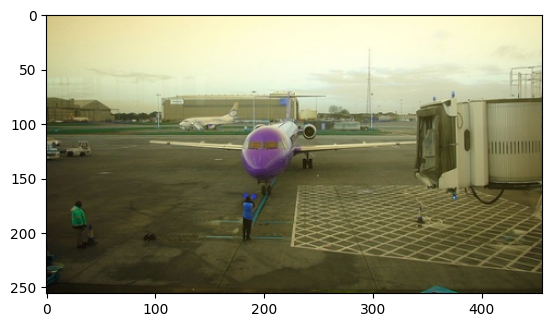

In [9]:
import matplotlib.pyplot as plt
plt.imshow(test_x['img'], cmap='gray',)

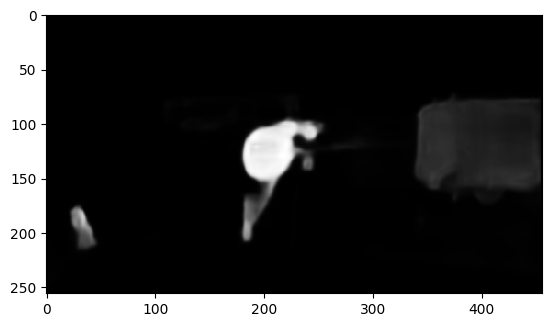

In [10]:
plt.imshow(test_x['sal_map'], cmap='gray',)

In [11]:
test_x=randomFlip(test_x)
# print(test_x['img'].shape,test_x['sal_map'].shape)

In [12]:
print(test_x['img'].shape,test_x['sal_map'].shape)

(256, 456, 3) (256, 456)


In [13]:
test_x=photoMetricDistortion(test_x)
print(test_x['img'].shape,test_x['sal_map'].shape)

(256, 456, 3) (256, 456)


In [14]:
test_x=randomCrop(test_x)
print(test_x['img'].shape,test_x['sal_map'].shape)

(256, 448, 3) (256, 448)


In [15]:
test_x

{'img_path': '/media/ders/mazhiming/mmseg4wsss/mmsegmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg',
 'seg_map_path': '/media/ders/mazhiming/mmseg4wsss/mmsegmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png',
 'sal_path': '/media/ders/mazhiming/mmseg4wsss/mmsegmentation/data/VOCdevkit/VOC2012/saliency_map/2007_000032.png',
 'reduce_zero_label': False,
 'seg_fields': ['gt_seg_map', 'sal_map'],
 'img': array([[[255, 255, 249],
         [255, 255, 249],
         [255, 255, 250],
         ...,
         [255, 255, 177],
         [255, 255, 176],
         [255, 255, 175]],
 
        [[255, 255, 252],
         [255, 255, 252],
         [255, 255, 253],
         ...,
         [255, 255, 178],
         [255, 255, 177],
         [255, 255, 176]],
 
        [[255, 255, 252],
         [255, 255, 253],
         [255, 255, 253],
         ...,
         [255, 255, 178],
         [255, 255, 178],
         [255, 255, 177]],
 
        ...,
 
        [[ 59,  53,  27],
       

In [16]:
test_x=packSegInputs(test_x)
# print(test_x['input'].shape,test_x['sal_map'].shape)

In [17]:
print(test_x['inputs'].shape,test_x['data_samples'].sal_map.data.shape)
segDataPpreprocessor=SegDataPreProcessor(bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        448,
        448,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],)

torch.Size([3, 256, 448]) torch.Size([1, 256, 448])


In [18]:
test_x['inputs']=[test_x['inputs']]
test_x['data_samples']=[test_x['data_samples']]
test_x=segDataPpreprocessor(test_x,training=True)

In [19]:
print(test_x['inputs'].shape,test_x['data_samples'][0].sal_map.data.shape)

torch.Size([1, 3, 448, 448]) torch.Size([1, 448, 448])


In [20]:
def transform_img(results):
    x=loadImg(results)
    x=loadAnn(x)
    print('--------load-------------------')
    print(x['img'].shape,x['sal_map'].shape)
    x=randomResize(x)
    print('--------resize-------------------')
    print(x['img'].shape,x['sal_map'].shape)
    x=randomFlip(x)
    print('--------flip-------------------')
    print(x['img'].shape,x['sal_map'].shape)
    x=photoMetricDistortion(x)#jetter
    print('--------jetter-------------------')
    print(x['img'].shape,x['sal_map'].shape)
    x=randomCrop(x)
    print('--------crop-------------------')
    print(x['img'].shape,x['sal_map'].shape)
    x=packSegInputs(x)
    print('--------pack-------------------')
    print(x['inputs'].shape,x['data_samples'].sal_map.data.shape)
    return x

In [21]:
results = dict(
    img_path=img_path,
    seg_map_path=gt_path,
    sal_path=sal_path,
    reduce_zero_label=False,
    seg_fields=[])
x=transform_img(results)

--------load-------------------
(281, 500, 3) (281, 500)
--------resize-------------------
(256, 456, 3) (256, 456)
--------flip-------------------
(256, 456, 3) (256, 456)
--------jetter-------------------
(256, 456, 3) (256, 456)
--------crop-------------------
(256, 448, 3) (256, 448)
--------pack-------------------
torch.Size([3, 256, 448]) torch.Size([1, 256, 448])


In [22]:
# x['data_samples'].gt_sem_seg.data

In [23]:
# x['data_samples']

In [24]:
x['data_samples'].sal_map.data.size()

torch.Size([1, 256, 448])

In [25]:
x['inputs'].size()

torch.Size([3, 256, 448])

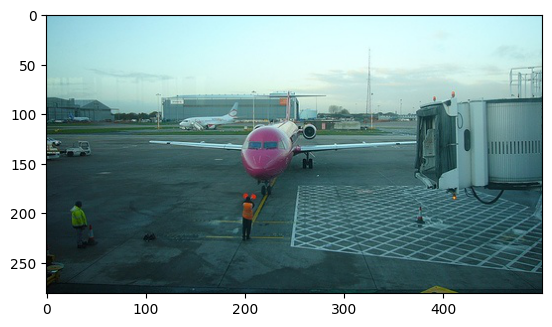

In [26]:
import matplotlib.pyplot as plt
import torch
img_or=plt.imread(img_path)
plt.imshow(img_or)

torch.Size([3, 256, 448])

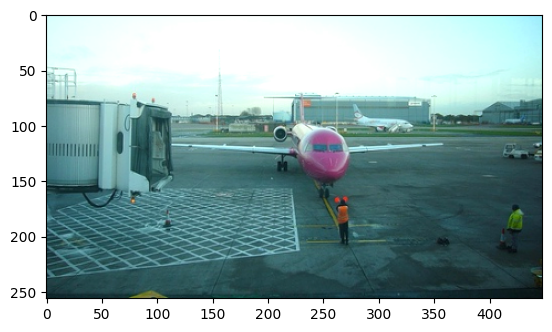

In [27]:
# normalize = Normalize()
# x['inputs'] = normalize(x['inputs'])
plt.imshow(x['inputs'].numpy().transpose(1,2,0)[...,::-1])
x['inputs'].shape

torch.Size([1, 256, 448])

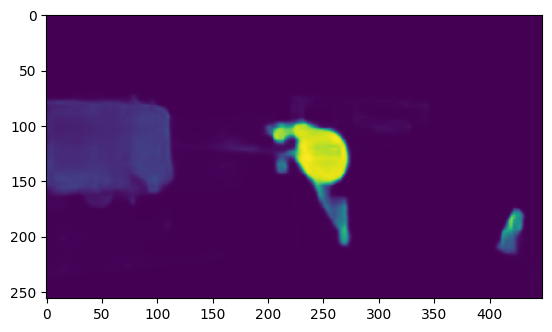

In [28]:
plt.imshow(x['data_samples'].sal_map.data.numpy().transpose(1,2,0)*255)
x['data_samples'].sal_map.data.shape

#stack_batch func

In [29]:
mean=[123.675, 116.28, 103.53]
std=[58.395, 57.12, 57.375]
pad_val=0
seg_pad_val=255
size=(448,448)
type='SegDataPreProcessor'
dataSamples=x['data_samples']
inputs=x['inputs']

In [30]:
# outputdata,padded_samples=stack_batch(inputs=[inputs], data_samples=[dataSamples],  size=size)

In [31]:
# outputdata.max()

In [32]:
# plt.imshow(outputdata[0].numpy().transpose(1,2,0))
# outputdata.shape

In [33]:
# padded_samples[0].sal_map.data.size()
# plt.imshow(padded_samples[0].sal_map.data.numpy().transpose(1,2,0))

In [34]:
# padded_samples[0].sal_map.data.max()
# 

In [35]:
segDataPpreprocessor=SegDataPreProcessor(bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        448,
        448,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],)

In [36]:
x['data_samples'].gt_sem_seg.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [37]:
x['inputs']=[x['inputs']]
x['data_samples']=[x['data_samples']]

In [38]:
input_of_model=segDataPpreprocessor(x,training=True)

In [39]:
input_of_model['inputs'].shape

torch.Size([1, 3, 448, 448])

In [40]:
# input_of_model['inputs']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


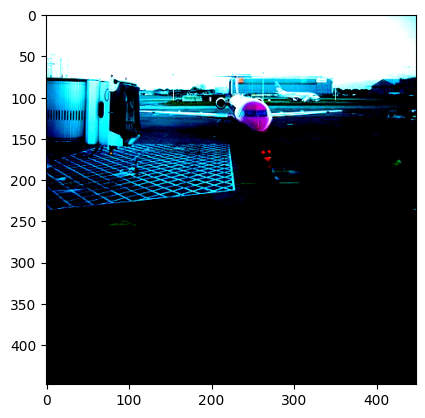

In [41]:
plt.imshow(input_of_model['inputs'][0].numpy().transpose(1,2,0))

In [42]:
input_of_model['data_samples'][0].sal_map.data.shape

torch.Size([1, 448, 448])

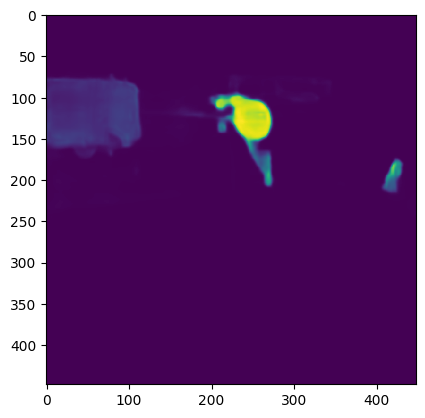

In [43]:
# input_of_model['data_samples'].sal_map.data.size()
show_sal=input_of_model['data_samples'][0].sal_map.data.numpy().transpose(1,2,0)*255
plt.imshow(show_sal)

In [44]:
input_of_model['data_samples'][0].sal_map.data.numpy()
show_sal=input_of_model['data_samples'][0].sal_map.data.numpy().transpose(1,2,0)
show_sal.shape

(448, 448, 1)

In [45]:
import numpy as np

# 假设 sal_map 是 saliency map，inputs 是原始图像
sal_map = input_of_model['data_samples'][0].sal_map.data.numpy().transpose(1, 2, 0) * 255
original_image = input_of_model['inputs'][0].numpy().transpose(1, 2, 0)

sal_map = np.array(sal_map, dtype=np.uint8)
original_image = np.array(original_image, dtype=np.uint8)

# 生成热力图
import cv2
heatmap = cv2.applyColorMap(sal_map, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
# heatmap_repeated = np.repeat(heatmap, 3, axis=2)

print(heatmap.shape, original_image.shape)

(448, 448, 3) (448, 448, 3)


In [46]:
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# 假设 sal_map 是 saliency map，inputs 是原始图像
sal_map = input_of_model['data_samples'][0].sal_map.data.numpy().transpose(1, 2, 0) * 255
original_image = input_of_model['inputs'][0].numpy().transpose(1, 2, 0)

sal_map = np.array(sal_map, dtype=np.uint8)
original_image = np.array(original_image, dtype=np.uint8)

# 生成热力图
import cv2
heatmap = cv2.applyColorMap(sal_map, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
# heatmap_repeated = np.repeat(heatmap, 3, axis=2)
map=cv2.addWeighted(heatmap, 0.4, original_image, 0.6, 0)

plt.imshow(map)




: 

In [ ]:
# plt.imsave('sal.png',show_sal)
# plt.imsave('sal.png',data_sample.sal_map.datadata_sample.sal_map.data)
# import matplotlib.pyplot as plt
# plt.imsave('sal.png',np.repeat(data_sample.sal_map.data.cpu().numpy().transpose(1,2,0),3,axis=-1))

In [ ]:
# pad_img
# show_sal=pad_img.data.cpu().numpy().transpose(1,2,0)
# plt.imsave('img.png',pad_img.data.cpu().numpy().transpose(1,2,0).astype(np.uint8))
# plt.imsave('img.png',pad_img.data.cpu().numpy().transpose(1,2,0).astype(np.uint8)*255)

In [ ]:
#vis backbone

In [ ]:
from mmseg.models.backbones.resnet38d import WideRes38

In [ ]:
res38=WideRes38()

In [ ]:
parameter_groups=res38.get_parameter_groups()

In [ ]:
len(parameter_groups)

In [ ]:
parameter_groups[0][0]

In [ ]:
backbone.conv1a,
backbone.b2.conv_branch2a,
backbone.b2.conv_branch2b1,
backbone.b2.conv_branch1,
backbone.b2_1.conv_branch2a,
backbone.b2_1.conv_branch2b1,
backbone.b2_2.conv_branch2a,
backbone.b2_2.conv_branch2b1,
backbone.b3.conv_branch2a,
backbone.b3.conv_branch2b1,
backbone.b3.conv_branch1,
backbone.b3_1.conv_branch2a,
backbone.b3_1.conv_branch2b1,
backbone.b3_2.conv_branch2a,
backbone.b3_2.conv_branch2b1,
backbone.b4.conv_branch2a,
backbone.b4.conv_branch2b1,
backbone.b4.conv_branch1,
backbone.b4_1.conv_branch2a,
backbone.b4_1.conv_branch2b1
backbone.b4_2.conv_branch2a
backbone.b4_2.conv_branch2b1
backbone.b4_3.conv_branch2a
backbone.b4_3.conv_branch2b1
backbone.b4_4.conv_branch2a
backbone.b4_4.conv_branch2b1
backbone.b4_5.conv_branch2a
backbone.b4_5.conv_branch2b1
backbone.b5.conv_branch2a
backbone.b5.conv_branch2b1
backbone.b5.conv_branch1
backbone.b5_1.conv_branch2a
backbone.b5_1.conv_branch2b1
backbone.b5_2.conv_branch2a
backbone.b5_2.conv_branch2b1
backbone.b6.conv_branch2a
backbone.b6.conv_branch2b1
backbone.b6.conv_branch2b2
backbone.b6.conv_branch1
backbone.b7.conv_branch2a
backbone.b7.conv_branch2b1
backbone.b7.conv_branch2b2
backbone.b7.conv_branch1


In [ ]:
backbone_layers = [
    'backbone.conv1a',
    'backbone.b2.conv_branch2a',
    'backbone.b2.conv_branch2b1',
    'backbone.b2.conv_branch1',
    'backbone.b2_1.conv_branch2a',
    'backbone.b2_1.conv_branch2b1',
    'backbone.b2_2.conv_branch2a',
    'backbone.b2_2.conv_branch2b1',
    'backbone.b3.conv_branch2a',
    'backbone.b3.conv_branch2b1',
    'backbone.b3.conv_branch1',
    'backbone.b3_1.conv_branch2a',
    'backbone.b3_1.conv_branch2b1',
    'backbone.b3_2.conv_branch2a',
    'backbone.b3_2.conv_branch2b1',
    'backbone.b4.conv_branch2a',
    'backbone.b4.conv_branch2b1',
    'backbone.b4.conv_branch1',
    'backbone.b4_1.conv_branch2a',
    'backbone.b4_1.conv_branch2b1',
    'backbone.b4_2.conv_branch2a',
    'backbone.b4_2.conv_branch2b1',
    'backbone.b4_3.conv_branch2a',
    'backbone.b4_3.conv_branch2b1',
    'backbone.b4_4.conv_branch2a',
    'backbone.b4_4.conv_branch2b1',
    'backbone.b4_5.conv_branch2a',
    'backbone.b4_5.conv_branch2b1',
    'backbone.b5.conv_branch2a',
    'backbone.b5.conv_branch2b1',
    'backbone.b5.conv_branch1',
    'backbone.b5_1.conv_branch2a',
    'backbone.b5_1.conv_branch2b1',
    'backbone.b5_2.conv_branch2a',
    'backbone.b5_2.conv_branch2b1',
    'backbone.b6.conv_branch2a',
    'backbone.b6.conv_branch2b1',
    'backbone.b6.conv_branch2b2',
    'backbone.b6.conv_branch1',
    'backbone.b7.conv_branch2a',
    'backbone.b7.conv_branch2b1',
    'backbone.b7.conv_branch2b2',
    'backbone.b7.conv_branch1'
]